# Run Pharaglow 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
# image io and analysis
import json
import pims
import trackpy as tp
# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features

### Load data and create binary masks 

In [2]:
%%time
# io
fname = "/media/scholz_la/hd2/Nicolina/Nicolina/20200123_NZ0021/*.tiff"
parameterfile = "/media/scholz_la/hd2/Nicolina/Nicolina/pharaglow_parameters_mks.txt"
outfile = "/media/scholz_la/hd2/Nicolina/Nicolina/20200123_NZ0021_{}_{}.json"
print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes[0:18000]
#print('Analyzing', rawframes)
print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)


Starting pharaglow analysis...
Loading parameters from ['Nicolina', 'pharaglow_parameters_mks.txt']
CPU times: user 33.4 ms, sys: 3.73 ms, total: 37.1 ms
Wall time: 41.5 ms


In [93]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = param['bgWindow']
                               , thresholdWindow = param['thresholdWindow'], smooth =  param['smooth'],
                               subtract =  param['subtract'])


Binarizing images
CPU times: user 39.5 s, sys: 1.4 s, total: 40.9 s
Wall time: 4.76 s


### Make sure the thesholding worked otherwise change parameters

2310


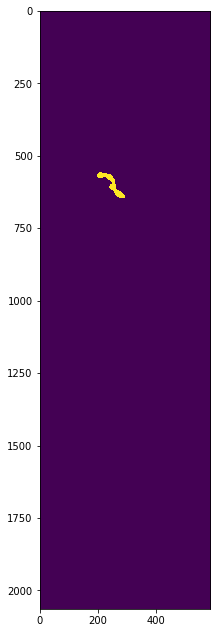

In [94]:
t = 1000
plt.figure(figsize=(18,11))
# plt.subplot(121)
plt.imshow(rawframes[t])
# plt.subplot(122)
plt.imshow(masks[t][:,2500:])
#plt.imshow(masks[t][ 250:750, 1800:2000])
#plt.imshow(masks[t][:, 1000:1250])

#np.sum(masks[t][500:750, 1000:1500])
#print(np.sum(masks[t][:, 1000:1250]))

#image = masks[t][ 350:750, 1600:2000]
#labeled = tracking.refine(image, size = param['watershed'])
#plt.imshow(labeled)
print(np.sum(masks[t][:,2500:]))

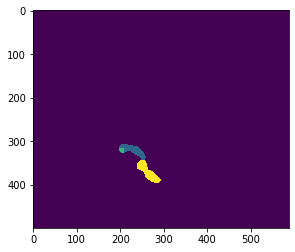

In [95]:
plt.imshow(tracking.refine(masks[t][250:750,2500:], size=80))

### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [96]:
%%time
import time

nWorkers = 20
if nWorkers ==1:

    #masks = tracking.preprocess(rawframes, minSize = param['minSize'], threshold =None )
    print('Detecting features')
    features = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
else:
    from multiprocessing import Pool
    print('Detecting features')
    def f(sl):
        a,b = sl
        #print(a,b)
        return tracking.runfeatureDetection(rawframes[a:b], masks[a:b], param, frameOffset = a)
    features = []
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
    print(L)
    chunksize = L//nWorkers//20
    #slices = np.arange(L)
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize, chunksize)))
    
    p = Pool(nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(f, slices)):
        features.append(res)
        if k ==10:
            print('Expected time is approx. {} s'.format(L/chunksize*(time.time()-start)/nWorkers))
        #print(p, time.time()-start)
    features = pd.concat(features)

Detecting features
2243
Expected time is approx. 281.6142773079872 s
CPU times: user 2.43 s, sys: 2.71 s, total: 5.15 s
Wall time: 6min 12s


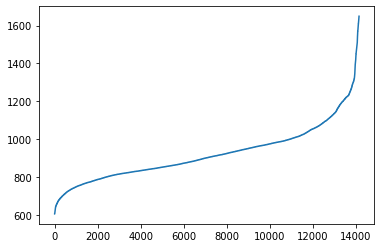

In [98]:

### Save the features
plt.plot(np.sort(features['area'].values))

In [99]:
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14139 entries, 0 to 0
Data columns (total 8 columns):
area     14139 non-null int64
frame    14139 non-null int64
image    14139 non-null object
slice    14139 non-null object
x        14139 non-null float64
xw       14139 non-null float64
y        14139 non-null float64
yw       14139 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 3.0 MB


In [36]:
features = pd.read_json(outfile.format('features', 'all'), orient='split', numpy = True)

In [101]:
print('Done')
print('Linking trajectories')
#trajectories = tracking.linkParticles(features, param['searchRange'], param['minimalDuration'])
#trajectories = tracking.linkParticles(features, 50, 500);
#trajectories = tp.link_df(features, 50, memory= 30)
#trajectories = tp.filter_stubs(trajectories,100)
pred = tp.predict.NearestVelocityPredict()
trajectories = pred.link_df(features, 10, memory= 300)

Frame 2239: 1 trajectories present.


In [102]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,300)
print(trajectories['particle'].nunique())

1840
6


### Show resulting trajectories

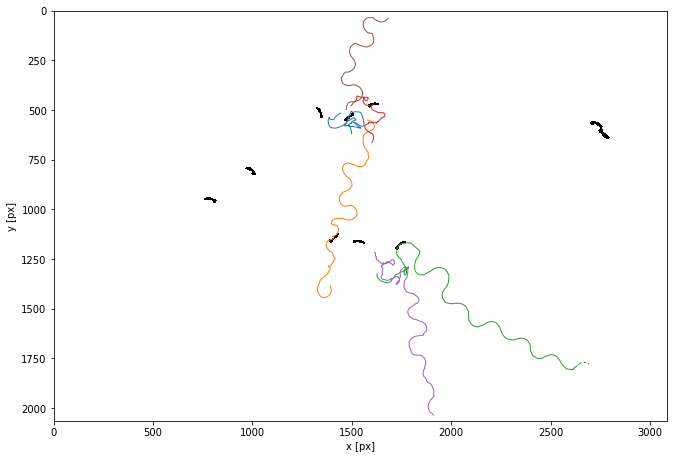

In [103]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories[trajectories['frame']<9000], superimpose=1-masks[1000]);

In [3]:
trajectories.to_json(outfile.format('trajectories', 'all'), orient='split')

NameError: name 'trajectories' is not defined

In [3]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

### run the whole pharaglow feature extraction

In [4]:
# read data
trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)

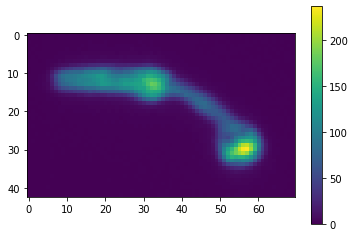

In [5]:
trajectories.head()
plt.imshow(trajectories['image'].iloc[100])
plt.colorbar()

In [5]:
# %%time
# print('Extracting pharynx data')
# trajectories = parallelize_dataframe(trajectories, run.runPharaglowOnStack, n_cores = 20, params = param)
# print('Done tracking. Successfully tracked {} frames with {} trajectorie(s).'.format(len(rawframes), trajectories['particle'].nunique()))

### Save data as hdf5 format (every trajectory in a file)

In [16]:
%%time
#trajectories.info(memory_usage='deep')

for particle_index in trajectories['particle'].unique():
    tmp = parallelize_dataframe(trajectories[trajectories.loc[:,'particle'] == particle_index], run.runPharaglowOnStack, n_cores = 20, params = param)
    print(np.max(tmp['Gradient'].iloc[0]))
    tmp.to_json(outfile.format('results', particle_index), orient='split')

[26, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

80
[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


53
[39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 104 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 103 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 102 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 100 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 101 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 98 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 97 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 96 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 95 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 91 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 111 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 90 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 112 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 88 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 89 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 109 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 107 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 103 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 104 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 93 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 101 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 102 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

78
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

76
[47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 111 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 112 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 102 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 101 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

76
[18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8
uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)


uint8


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered

102
CPU times: user 5.94 s, sys: 3.71 s, total: 9.66 s
Wall time: 1min 31s
